In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Homework 7: Sentiment Classification with Pre-trained and Re-trained GloVe Embeddings

## Due: Midnight on October 19th @ Midnight (with 2-hour grace period) and worth 85 points.

In this notebook, we’ll continue with the investigation of text classification using "Bag of Embeddings" models and the IMDB movie review dataset.
We'll focus on unfrozen embeddings, which refine the embedding space based on your dataset.

You'll do three problems:

* **Problem One:** Build a baseline model with unfrozen embeddings and experiment with architectural and training adjustments to improve performance.
* **Problem Two:** Investigate how increasing the maximum message length and vocabulary size affects model accuracy and generalization.
* **Problem Three:** Examine the impact of changing the embedding dimension on model performance.


In each problem, you'll report your best validation accuracy and reflect on what you have learned.

### Useful Imports

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import Counter


from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential, callbacks, regularizers, initializers
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import LayerNormalization, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,GlobalMaxPooling1D, Flatten
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import StratifiedShuffleSplit


# Reproducibility

random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# utility code

from datetime import datetime

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

'''  How to time your code
# start timer
start_time = time.time()

<your code here>

# Record end time and print execution time
print(f"Execution Time: " + format_time(time.time()-start_time))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far
- We've also added  `

In [3]:
def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_test,y_test` already defined, will access them as global variables.
- If `X_val` and `y_val` defined, will use those, else assumes `validation_split = 0.2` in `fit`


**Note:** See the end of the notebook for results and parameter settings.

In [4]:
def train_and_test(model,
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults
                   clipnorm      = None,
                   batch_size    = 128,
                   loss          = "binary_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule,clipnorm=clipnorm)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer = opt,
                  loss      = loss,
                  metrics   = metrics
                 )



    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        )
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    # If X_val defined, then  use it, else assume val is split from train

    if 'X_val' in globals():
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=cbs,
                            verbose=verbose
                           )
    else:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,
                            callbacks=cbs,
                            verbose=verbose
                           )

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    min_val_epoch = np.argmin(history.history['val_loss'])
    # Retrieve the values at that epoch
    min_val_loss = history.history['val_loss'][min_val_epoch]
    # Get corresponding validation accuracy at that epoch
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results

    print(f"\nFinal Training Loss:            {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings

    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "callbacks": _summarize_callbacks(callbacks),
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)

    if return_history:
        return history

def _summarize_callbacks(cbs):
    if cbs is None:
        return None
    out = []
    for cb in cbs:
        name = getattr(cb, "__class__", type(cb)).__name__
        info = {"class": name}
        # grab a few common attributes if present
        for attr in ("monitor", "mode", "patience", "min_delta",
                     "factor", "min_lr", "verbose", "cooldown"):
            if hasattr(cb, attr):
                info[attr] = getattr(cb, attr)
        out.append(info)
    return out

results = {}
parameter_settings = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])


### Prelude:  A little EDA: Distribution of review lengths and coverage by max vocabulary size

You will use this to think about where the set parameters for maximum review length and the maximum number of unique tokens to use.


Total unique words in Keras IMDB word_index (corpus-wide): 88,584
Num training reviews: 25,000
Max length: 2,494 tokens
Mean length: 238.7 tokens
Median length: 178 tokens
90th percentile: 467 tokens
95th percentile: 610 tokens
99th percentile: 926 tokens


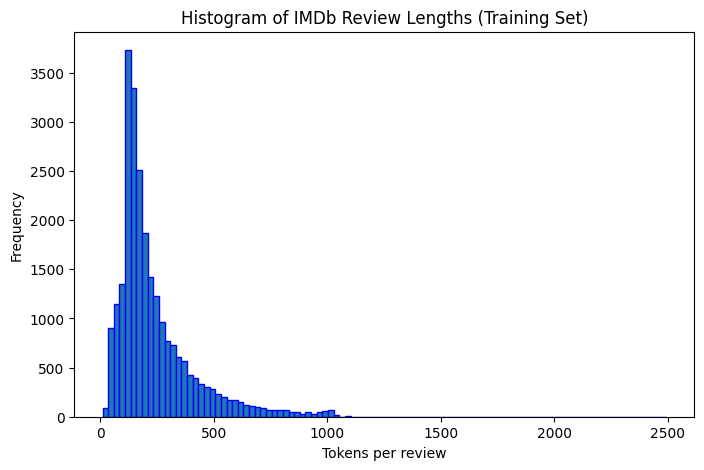


Unique word types in TRAIN (id >= 3): 88,583
Total word tokens in TRAIN (id >= 3): 5,942,840

Coverage metrics by candidate vocab size (TRAIN split):
training_vocabulary_size= 2,000 | coverage= 82.84% | OOV= 17.16% | types kept=  1,997 | tokens kept= 4,922,766
training_vocabulary_size= 5,000 | coverage= 90.03% | OOV=  9.97% | types kept=  4,997 | tokens kept= 5,350,551
training_vocabulary_size=10,000 | coverage= 94.25% | OOV=  5.75% | types kept=  9,997 | tokens kept= 5,601,261
training_vocabulary_size=20,000 | coverage= 97.22% | OOV=  2.78% | types kept= 19,997 | tokens kept= 5,777,376
training_vocabulary_size=30,000 | coverage= 98.37% | OOV=  1.63% | types kept= 29,997 | tokens kept= 5,846,141
training_vocabulary_size=50,000 | coverage= 99.32% | OOV=  0.68% | types kept= 49,997 | tokens kept= 5,902,246
training_vocabulary_size=70,000 | coverage= 99.69% | OOV=  0.31% | types kept= 69,997 | tokens kept= 5,924,254
training_vocabulary_size=88,584 | coverage=100.00% | OOV=  0.00% | types

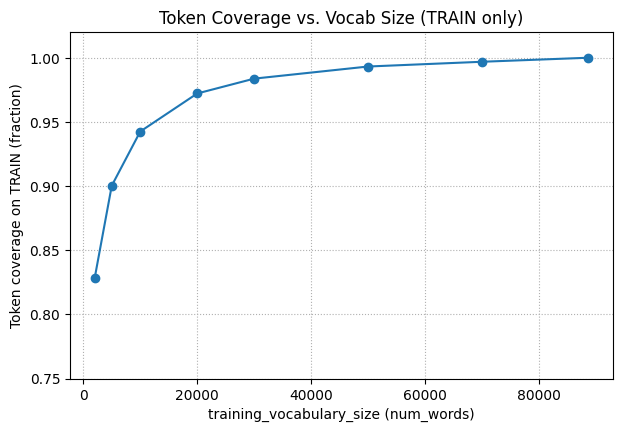

In [6]:
# IMDB vocab & length stats + coverage table + single coverage plot

from tensorflow.keras.datasets import imdb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Load IMDB with NO cap (so we can measure coverage fairly)
# ---------------------------------------
(X_tr, y_tr), _ = imdb.load_data()

# ---------------------------------------
# 1) Global vocab stats (from Keras word_index)
# ---------------------------------------
word_index = imdb.get_word_index()  # mapping: word -> rank (lower rank = more frequent)
total_unique_words_corpus = len(word_index)  # across the full IMDB corpus Keras ships
print(f"Total unique words in Keras IMDB word_index (corpus-wide): {total_unique_words_corpus:,}")

# ---------------------------------------
# 2) Training review length stats + histogram (students pick max_text_length)
# ---------------------------------------
lengths = np.fromiter((len(r) for r in X_tr), dtype=np.int32)
print(f"Num training reviews: {len(lengths):,}")
print(f"Max length: {lengths.max():,} tokens")
print(f"Mean length: {lengths.mean():.1f} tokens")
print(f"Median length: {np.median(lengths):.0f} tokens")
for q in (90, 95, 99):
    print(f"{q}th percentile: {int(np.percentile(lengths, q))} tokens")

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=100, edgecolor='b')
plt.title("Histogram of IMDb Review Lengths (Training Set)")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------
# 3) Training-only frequency counts for real words (ids >= 3)
#    IMDB ID conventions: 0=<PAD>, 1=<START>, 2=<OOV>, >=3 actual words
# ---------------------------------------
def iter_tokens(seqs):
    for s in seqs:
        for t in s:
            yield t

train_counts = Counter(t for t in iter_tokens(X_tr) if t >= 3)

# Frequency list (descending) and cumulative token coverage
freqs = np.array(sorted(train_counts.values(), reverse=True), dtype=np.int64)
cum_tokens = np.cumsum(freqs)
total_tokens_train_words = int(cum_tokens[-1])
num_unique_words_train = int(len(freqs))

print(f"\nUnique word types in TRAIN (id >= 3): {num_unique_words_train:,}")
print(f"Total word tokens in TRAIN (id >= 3): {total_tokens_train_words:,}")

# ---------------------------------------
# 4) Coverage helper for a given num_words cap (Keras convention)
#    Valid word ids are [3, num_words_cap-1] → ranks [1 .. num_words_cap-3]
# ---------------------------------------
def coverage_for_cap(num_words_cap: int):
    kept_types = max(0, min(num_words_cap - 3, num_unique_words_train))
    kept_tokens = int(cum_tokens[kept_types - 1]) if kept_types > 0 else 0
    oov_tokens = total_tokens_train_words - kept_tokens
    coverage = kept_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    oov_share = oov_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    return dict(
        cap=num_words_cap,
        kept_tokens=kept_tokens,
        kept_types=kept_types,
        coverage=coverage,
        oov_share=oov_share
    )

# ---------------------------------------
# 5) Candidate vocab sizes: ASCII table + single coverage plot
# ---------------------------------------
candidate_caps = [2_000, 5_000, 10_000, 20_000, 30_000, 50_000, 70_000, 88_584]  # students can edit
rows = [coverage_for_cap(k) for k in candidate_caps]

print("\nCoverage metrics by candidate vocab size (TRAIN split):")
for r in rows:
    print(f"training_vocabulary_size={r['cap']:>6,} | coverage={r['coverage']*100:6.2f}% | "
          f"OOV={r['oov_share']*100:6.2f}% | types kept={r['kept_types']:>7,} | tokens kept={r['kept_tokens']:>10,}")

plt.figure(figsize=(7, 4.5))
plt.plot(candidate_caps, [r['coverage'] for r in rows], marker='o')
plt.xlabel("training_vocabulary_size (num_words)")
plt.ylabel("Token coverage on TRAIN (fraction)")
plt.title("Token Coverage vs. Vocab Size (TRAIN only)")
plt.grid(True, linestyle=":")
plt.ylim(0.75, 1.02)
plt.show()


### Load and preprocess dataset

Here is where you can set the
- `training_vocabulary_size` and
- `max_text_length`

In [57]:
# Load and preprocess dataset into padded sequences of token IDs

training_vocabulary_size = 50_000              # <-----
max_text_length          = 1000                  # <-----

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )

X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)



X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)


X_train.shape,X_test.shape

((40000, 1000), (10000, 1000))

### Build the embedding matrix

Here is where you can set
- `embedding_dimension`


In [62]:
#  Build embedding matrix


embedding_dimension = 200                    # <-----

word_index      = imdb.get_word_index()

glove_path = Path(f"drive/MyDrive/glove.6B/glove.6B.{embedding_dimension}d.txt")

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        try:
            embeddings_index[word] = np.asarray(vec, dtype='float32')
        except ValueError:
            # Skip words that cause conversion errors (e.g., '-')
            continue


# Build embedding matrix

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

### Baseline Model from the Coding Notebook


model_baseline (frozen)



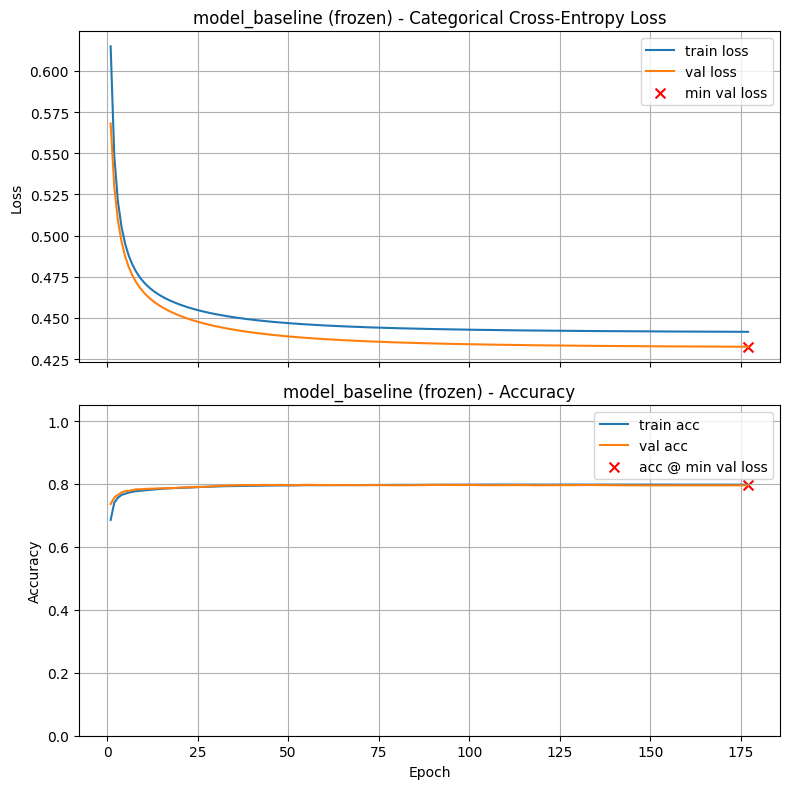


Execution Time: 00:01:48

Final Training Loss:            0.4415
Final Training Accuracy:        0.7978
Final Validation Loss:          0.4325
Final Validation Accuracy:      0.7956
Minimum Validation Loss:        0.4325 (Epoch 177)
Validation Accuracy @ Min Loss: 0.7956

Test Loss: 0.4336
Test Accuracy: 0.8065

Validation-Test Accuracy Gap: 0.010875


In [9]:

model_baseline_frozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = False                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])


train_and_test(model_baseline_frozen,  lr_schedule=1e-2, title="model_baseline (frozen)")

#### End of Template Code from Coding Notebook

## Problem One: Baseline with Unfrozen Embeddings

**ToDo:**

1. Establish a baseline for unfrozen embeddings by running the baseline model but with `trainable = True` to retrain the embeddings as it trains on the the classification task. You will use retrainable embeddings throughout the homework.

2. Now run 2-3 experiments to try to improve this baseline:

    - Consider adding a Dense layer between the global average pooling and the output layer, with
        - Your choice of size
        - Your choice of L2 regularizatio (or not)
        - Your choice of dropout (or not)
3. As needed, tweak the learning rate (try `1e-4`) and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Define your best model for unfrozen embeddings based on these experiments (you will use it in the remaining two problems)
5. Answer the graded questions

**Note:** Generally, you will need a lower learning rate for retrainable embeddings.


model_baseline (unfrozen)



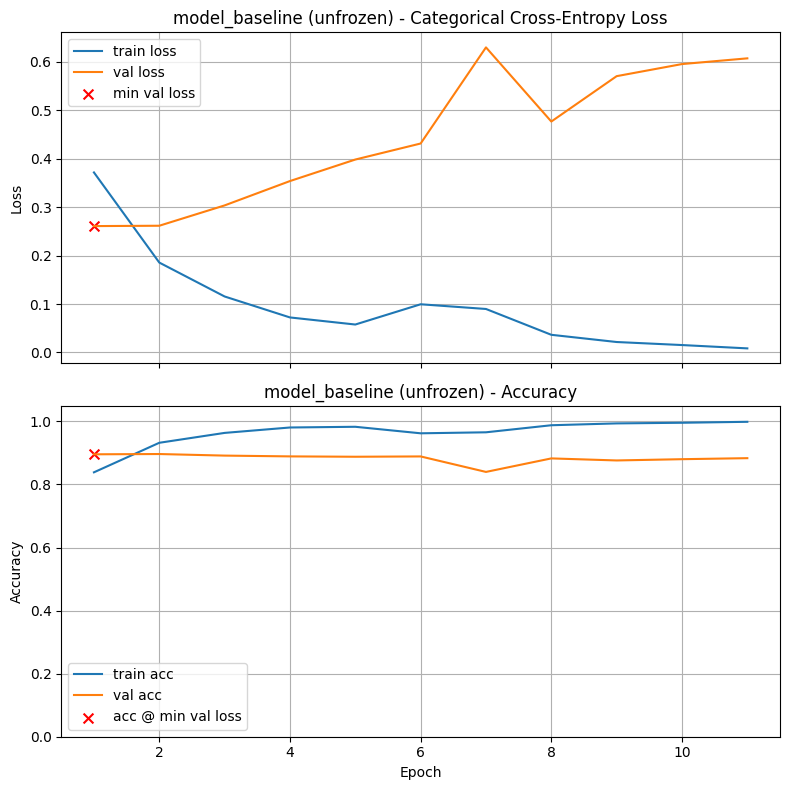


Execution Time: 00:00:14

Final Training Loss:            0.0085
Final Training Accuracy:        0.9987
Final Validation Loss:          0.6069
Final Validation Accuracy:      0.8834
Minimum Validation Loss:        0.2608 (Epoch 1)
Validation Accuracy @ Min Loss: 0.8956

Test Loss: 0.2683
Test Accuracy: 0.8918

Validation-Test Accuracy Gap: 0.003825


In [10]:
model_baseline_unfrozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = True                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_unfrozen,  lr_schedule=1e-2, title="model_baseline (unfrozen)")


model_baseline (unfrozen) w/ additional 256 dense layer, l2 regularizer



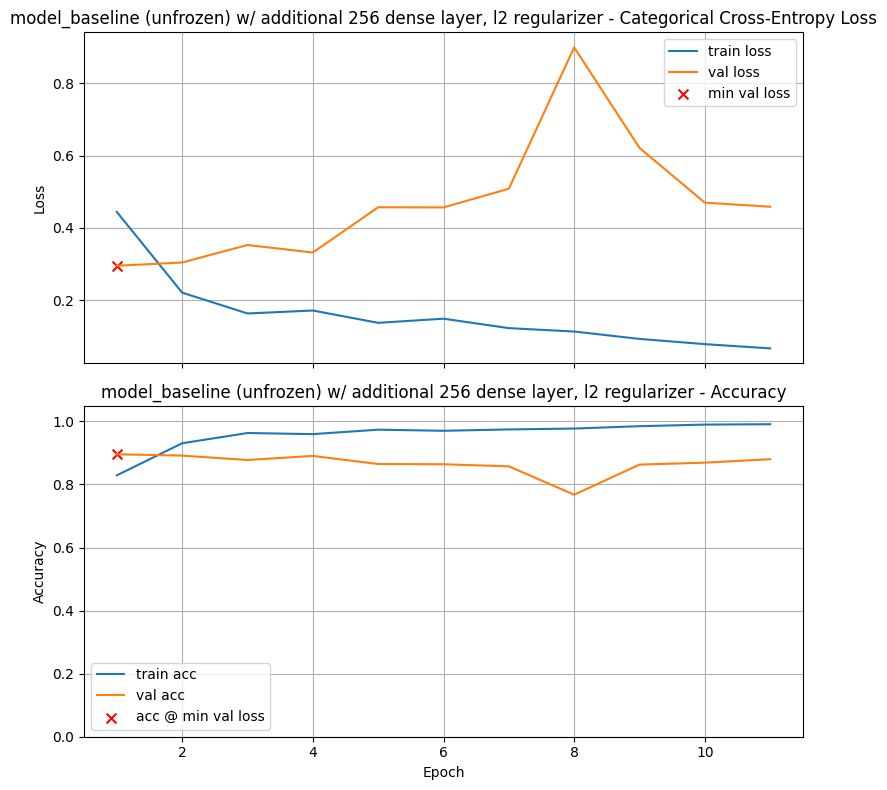


Execution Time: 00:00:15

Final Training Loss:            0.0668
Final Training Accuracy:        0.9910
Final Validation Loss:          0.4585
Final Validation Accuracy:      0.8801
Minimum Validation Loss:        0.2954 (Epoch 1)
Validation Accuracy @ Min Loss: 0.8957

Test Loss: 0.2988
Test Accuracy: 0.8915

Validation-Test Accuracy Gap: 0.004250


In [11]:
model_baseline_256_l2 = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = True                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2()),
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_256_l2,  lr_schedule=1e-2, title="model_baseline (unfrozen) w/ additional 256 dense layer, l2 regularizer")


model_baseline (unfrozen) w/ additional 256 dense layer, l2 regularizer, dropout (0.1)



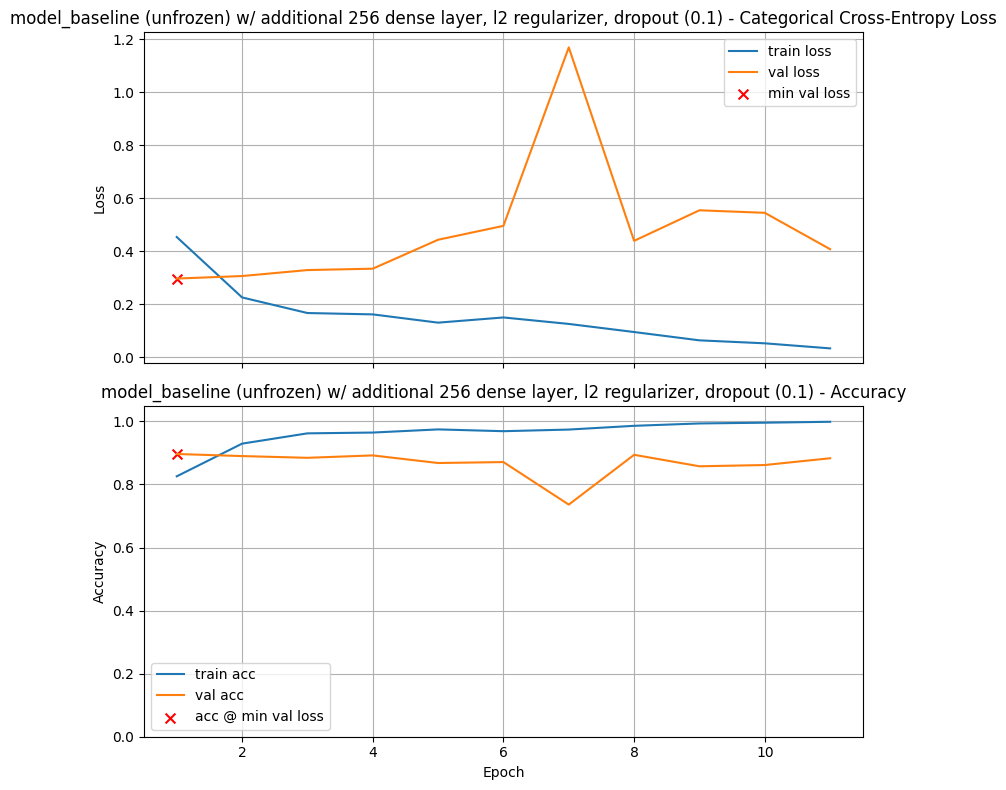


Execution Time: 00:00:16

Final Training Loss:            0.0339
Final Training Accuracy:        0.9987
Final Validation Loss:          0.4079
Final Validation Accuracy:      0.8831
Minimum Validation Loss:        0.2972 (Epoch 1)
Validation Accuracy @ Min Loss: 0.8966

Test Loss: 0.3005
Test Accuracy: 0.8927

Validation-Test Accuracy Gap: 0.003925


In [12]:
model_baseline_256_l2_do = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = True                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2()),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

train_and_test(model_baseline_256_l2_do,  lr_schedule=1e-2, title="model_baseline (unfrozen) w/ additional 256 dense layer, l2 regularizer, dropout (0.1)")


model_baseline (unfrozen) w/ additional 256 dense layer, dropout (0.1), l2 regularizer, new fixed lr



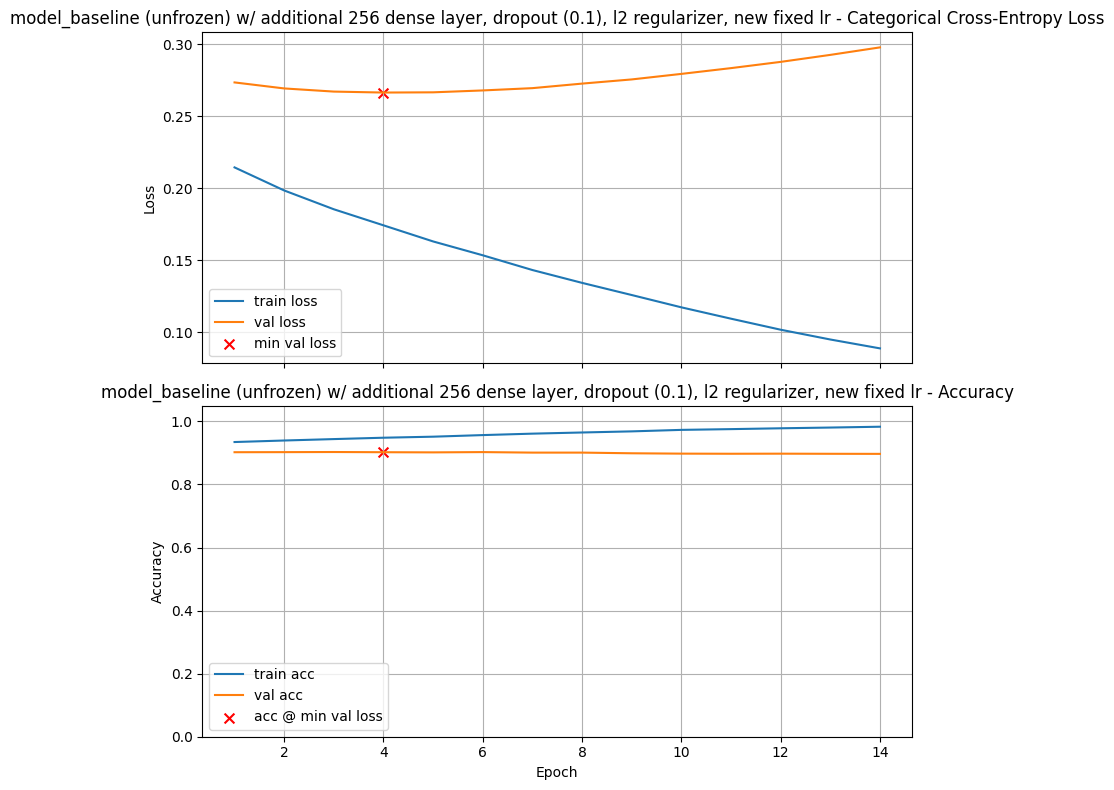


Execution Time: 00:00:20

Final Training Loss:            0.0890
Final Training Accuracy:        0.9831
Final Validation Loss:          0.2980
Final Validation Accuracy:      0.8970
Minimum Validation Loss:        0.2666 (Epoch 4)
Validation Accuracy @ Min Loss: 0.9022

Test Loss: 0.2775
Test Accuracy: 0.9001

Validation-Test Accuracy Gap: 0.002150


In [13]:
# Run the best model with new learning rate
train_and_test(model_baseline_256_l2_do,  lr_schedule=8e-4, title="model_baseline (unfrozen) w/ additional 256 dense layer, dropout (0.1), l2 regularizer, new fixed lr")


model_baseline (unfrozen) w/ additional 256 dense layer, dropout (0.1), l2 regularizer, new lr w/ reduction


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


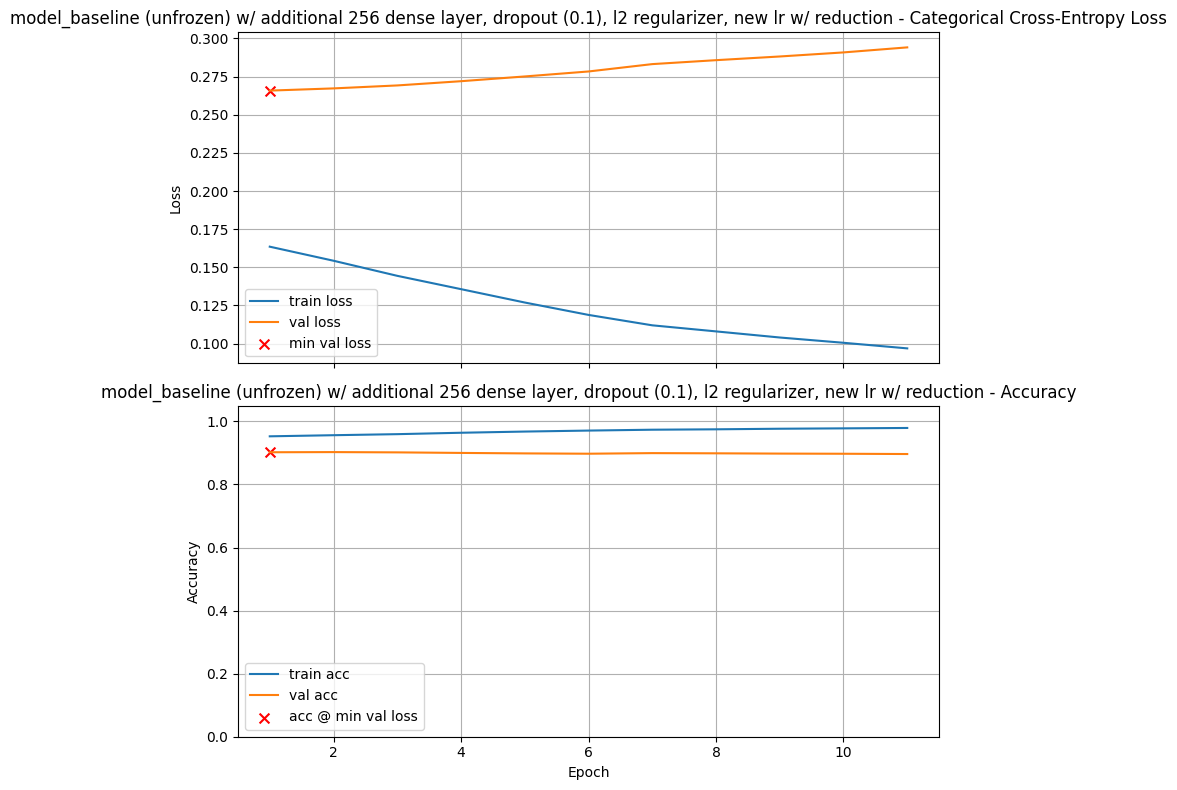


Execution Time: 00:00:16

Final Training Loss:            0.0969
Final Training Accuracy:        0.9792
Final Validation Loss:          0.2942
Final Validation Accuracy:      0.8965
Minimum Validation Loss:        0.2658 (Epoch 1)
Validation Accuracy @ Min Loss: 0.9021

Test Loss: 0.2772
Test Accuracy: 0.9010

Validation-Test Accuracy Gap: 0.001125


In [14]:
# Add learning rate scheduling to the model
train_and_test(model_baseline_256_l2_do,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model_baseline (unfrozen) w/ additional 256 dense layer, dropout (0.1), l2 regularizer, new lr w/ reduction")

### Graded Questions

#### Question a1a:

In [26]:
# Set a1a to the validation accuracy for your best model found in this problem

a1a = .9022            # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.9022


#### Question a1b: Describe below your experiments. What worked and what didn't?    

#### Your Answer Here: Decided to add a Dense 256 layer just before the output layer, this saw imporvement over the baseline model of a small percentage. Adding l2 regularization and a dropoutset of (0.1) also saw small improvements. Adding the learning rate scheduler saw the most minimal improvement overall.




## Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

We might expect that increasing the amount of data by increasing the maximum message length and the vocabulary size would improve results,
but maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem One

2. Consult the information shown in the EDA cells above, and run 2-3 experiments to try to improve this model by increasing either or both of:

    - `max_text_length`, and
    - `training_vocabulary_size`
3. As needed, tweak the learning rate and try it with or without Reduce on Plateau (you can tweak the parametera there as well)
4. Define your best model for use in Problem Three
5. Answer the graded questions

**Note:** `train_and_test` accesses the training and testing files as globals. You can cut and paste copies of the cells which load, preprocess, and build the embeddings for the dataset,
but you'll be **redefining the global names,** just be careful about the order in which you run cells. As an alternative, you can change the parameters in the code in the Prelude, and
just run this problem here.


model (unfrozen) w/ max text length 1000


Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


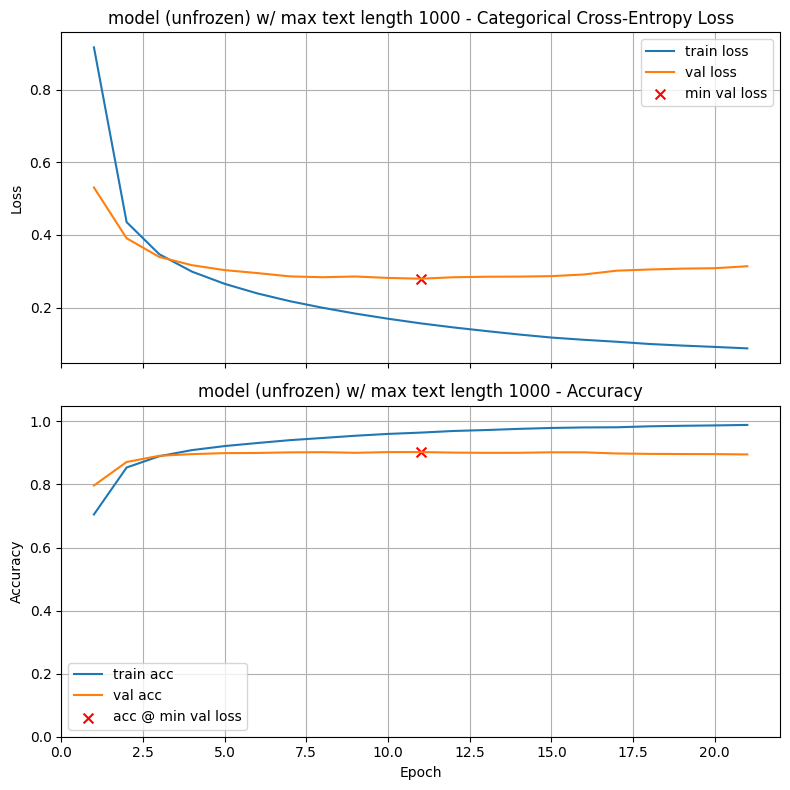


Execution Time: 00:00:33

Final Training Loss:            0.0873
Final Training Accuracy:        0.9888
Final Validation Loss:          0.3138
Final Validation Accuracy:      0.8953
Minimum Validation Loss:        0.2794 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9028

Test Loss: 0.2921
Test Accuracy: 0.9002

Validation-Test Accuracy Gap: 0.002550


In [35]:
# New model with updated max text length
model_newtextlength = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = True                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2()),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Add learning rate scheduling to the model
train_and_test(model_newtextlength,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model (unfrozen) w/ max text length 1000")


model (unfrozen) w/ training vocabulary size 70,000


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


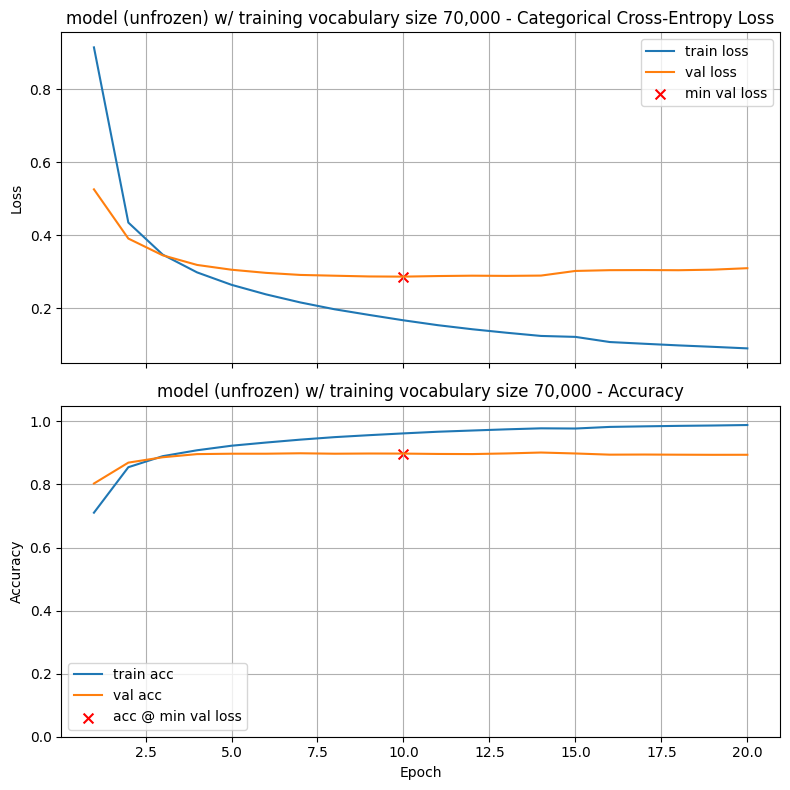


Execution Time: 00:00:26

Final Training Loss:            0.0893
Final Training Accuracy:        0.9885
Final Validation Loss:          0.3093
Final Validation Accuracy:      0.8941
Minimum Validation Loss:        0.2862 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8979

Test Loss: 0.2960
Test Accuracy: 0.8978

Validation-Test Accuracy Gap: 0.000075


In [39]:
# New model with updated training vocab size
model_newvocabsize = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = True                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2()),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Add learning rate scheduling to the model
train_and_test(model_newvocabsize,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model (unfrozen) w/ training vocabulary size 70,000")


model (unfrozen) w/ training vocabulary size 70,000 and max text length 1000


Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


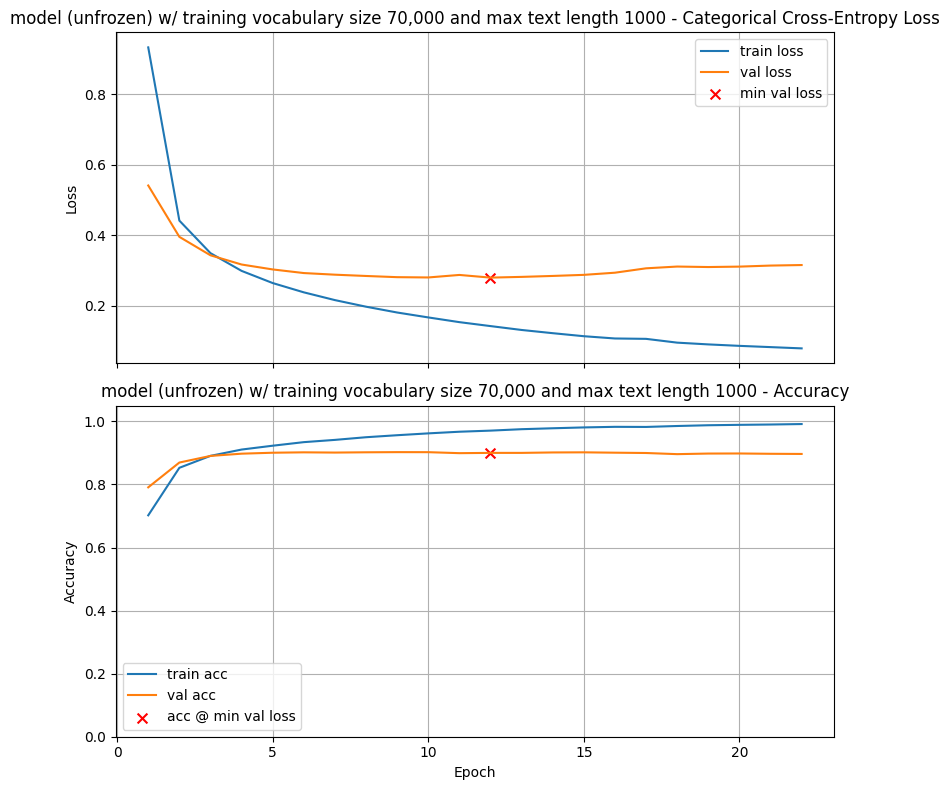


Execution Time: 00:00:37

Final Training Loss:            0.0783
Final Training Accuracy:        0.9916
Final Validation Loss:          0.3149
Final Validation Accuracy:      0.8967
Minimum Validation Loss:        0.2792 (Epoch 12)
Validation Accuracy @ Min Loss: 0.9001

Test Loss: 0.2918
Test Accuracy: 0.9018

Validation-Test Accuracy Gap: 0.001675


In [42]:
# New model with updated training vocab size
model_vocabandtextlength = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,
        output_dim = embedding_dimension,
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = True                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2()),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Add learning rate scheduling to the model
train_and_test(model_vocabandtextlength,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model (unfrozen) w/ training vocabulary size 70,000 and max text length 1000")

### Graded Questions

In [43]:
# Set a1a to the validation accuracy for your best model found in this problem

a2a = 0.9028             # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.9028


#### Question a2b: Describe below your experiments. What effect did your changes to the dataset have? Did it help as you as you expected?   

#### Your Answer Here: The only imporovements made to the model was the adjustment of the max text length, increases to the training vocabulary size didn't improve the performance of the model, in fact it was slightly worse when implemented.

## Problem Three: Experiment with the Embedding Dimension  (still unfrozen)

We might expect that increasing the embedding dimension would improve your results!
Again, maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem Two (which used an embedding dimension of 100)
2. Try an embedding dimension of 300 to see the effect. (Optional: Try 50 and 200 as well.)
3. As necessary weak the learning rate and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Answer the graded questions


model (unfrozen) w/ embedding dimension 300


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


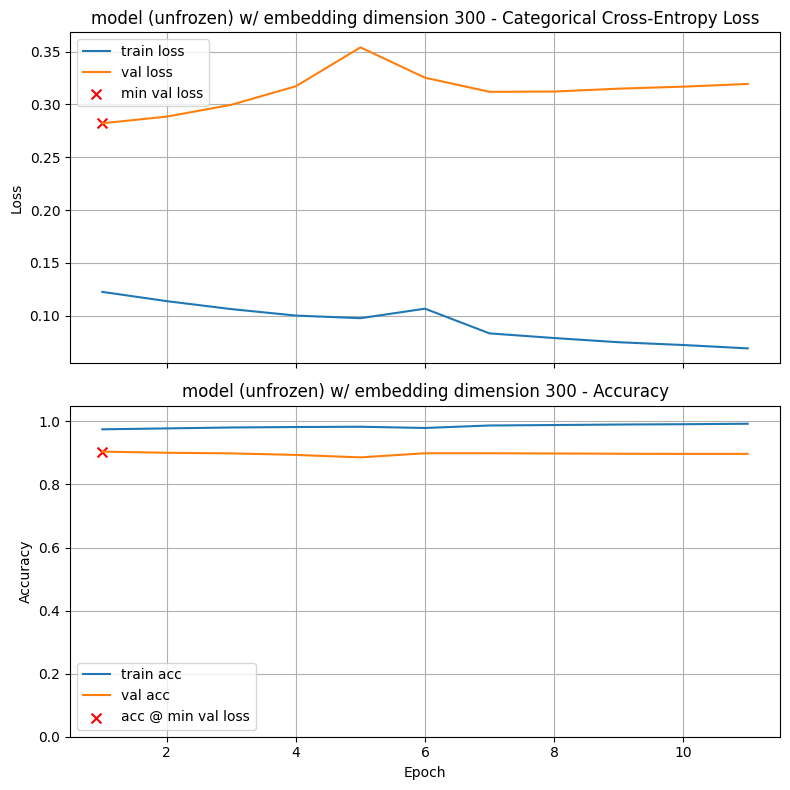


Execution Time: 00:00:19

Final Training Loss:            0.0691
Final Training Accuracy:        0.9925
Final Validation Loss:          0.3195
Final Validation Accuracy:      0.8970
Minimum Validation Loss:        0.2822 (Epoch 1)
Validation Accuracy @ Min Loss: 0.9041

Test Loss: 0.2970
Test Accuracy: 0.9014

Validation-Test Accuracy Gap: 0.002725


In [59]:
# Updating embedding to 300
train_and_test(model_newtextlength,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model (unfrozen) w/ embedding dimension 300")


model (unfrozen) w/ embedding dimension 50


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


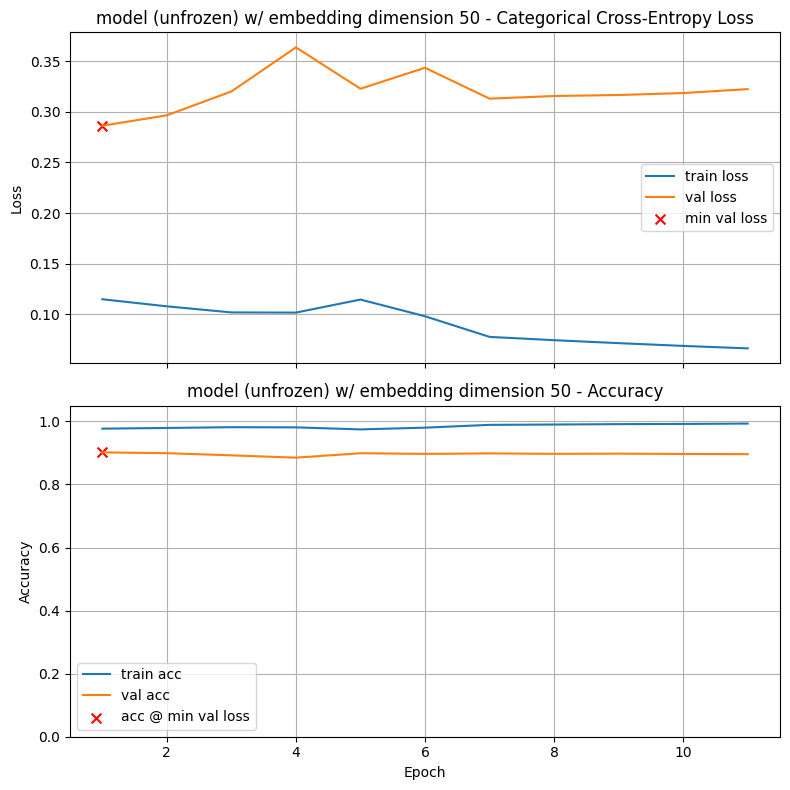


Execution Time: 00:00:19

Final Training Loss:            0.0663
Final Training Accuracy:        0.9932
Final Validation Loss:          0.3223
Final Validation Accuracy:      0.8961
Minimum Validation Loss:        0.2862 (Epoch 1)
Validation Accuracy @ Min Loss: 0.9018

Test Loss: 0.3007
Test Accuracy: 0.9003

Validation-Test Accuracy Gap: 0.001450


In [61]:
# Updating embedding to 50
train_and_test(model_newtextlength,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model (unfrozen) w/ embedding dimension 50")


model (unfrozen) w/ embedding dimension 200


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.


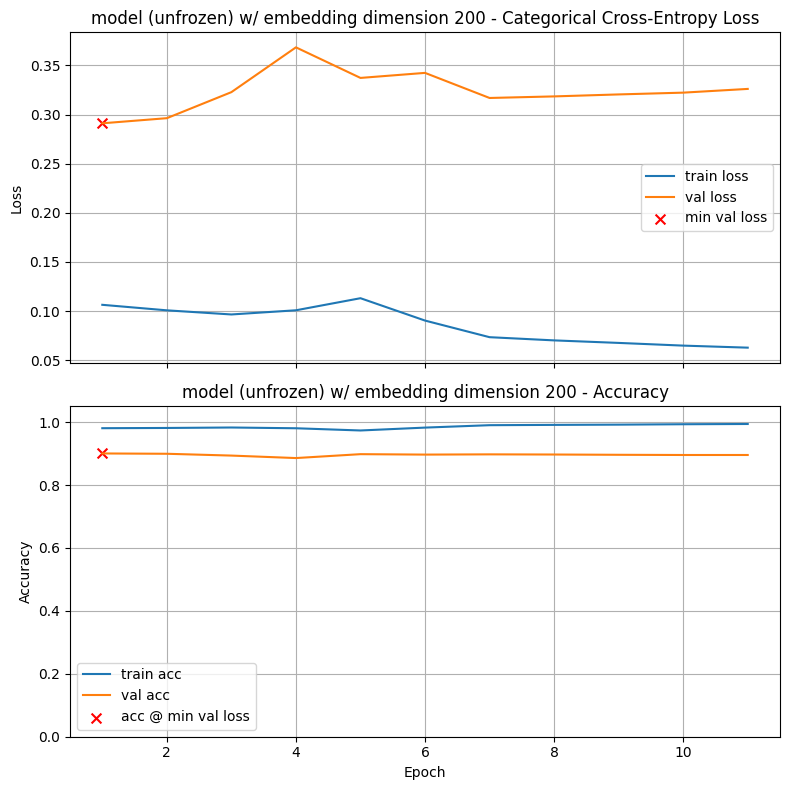


Execution Time: 00:00:19

Final Training Loss:            0.0627
Final Training Accuracy:        0.9940
Final Validation Loss:          0.3261
Final Validation Accuracy:      0.8955
Minimum Validation Loss:        0.2911 (Epoch 1)
Validation Accuracy @ Min Loss: 0.9004

Test Loss: 0.3056
Test Accuracy: 0.9000

Validation-Test Accuracy Gap: 0.000375


In [63]:
# Updating embedding to 200
train_and_test(model_newtextlength,  lr_schedule=8e-4, callbacks=[reduce_lr], title="model (unfrozen) w/ embedding dimension 200")

### Graded Questions

In [64]:
# Set a1a to the validation accuracy for your best model found in this problem

a3a = 0.9041            # Replace 0.0 with your answer

In [65]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.9041


#### Question a3b: Describe below your experiments. What effect did increasing the dimension from 100 to 300 have? Did it help as you as you expected?  

#### Your Answer Here: I went and updated the global dimension variable before each run, and then tracked the results. The best performing dimension was 300, but not by much.

In [66]:
print_results()

model (unfrozen) w/ embedding dimension 300	0.9041	1
model (unfrozen) w/ max text length 1000	0.9028	11
model_baseline (unfrozen) w/ additional 256 dense layer, dropout (0.1), l2 regularizer, new fixed lr	0.9022	4
model_baseline (unfrozen) w/ additional 256 dense layer, dropout (0.1), l2 regularizer, new lr w/ reduction	0.9021	1
model (unfrozen) w/ embedding dimension 50	0.9018	1
model (unfrozen) w/ embedding dimension 200	0.9004	1
model (unfrozen) w/ training vocabulary size 70,000 and max text length 1000	0.9001	12
model (unfrozen) w/ training vocabulary size 60_000	0.8980	11
model (unfrozen) w/ training vocabulary size 70,000	0.8979	10
model_baseline (unfrozen) w/ additional 256 dense layer, l2 regularizer, dropout (0.1)	0.8966	1
model_baseline (unfrozen) w/ additional 256 dense layer, l2 regularizer	0.8957	1
model_baseline (unfrozen)               	0.8956	1
model_baseline (frozen)                 	0.7956	177


In [67]:
# This will have recorded details of all your experiments

parameter_settings

{'model_baseline (frozen)': [{'title': 'model_baseline (frozen)',
   'timestamp': '2025-10-15T02:27:50',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_size': 128,
   'use_early_stopping': True,
   'patience': 10,
   'min_delta': 0.0001,
   'callbacks': [],
   'Final Training Loss': 0.44153034687042236,
   'Final Training Accuracy': 0.797781229019165,
   'Final Val Loss': 0.4324704110622406,
   'Final Val Accuracy': 0.7956249713897705,
   'Min Val Loss': 0.4324704110622406,
   'Min Val Loss Epoch': np.int64(176),
   'Val Acc @ Min Loss': 0.7956249713897705,
   'Test Loss': 0.4335835874080658,
   'Test Acc': 0.8065000176429749,
   'Val-Test Accuracy Gap:': 0.010875046253204346}],
 'model_baseline (unfrozen)': [{'title': 'model_baseline (unfrozen)',
   'timestamp': '2025-10-15T02:28:05',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy'